In [2]:
import pandas as pd

import keras
from keras import layers
import keras.backend
from keras.layers import Input, Conv1D, MaxPool1D, Flatten, Dense, BatchNormalization, Dropout
from keras import models
import keras.utils

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

### 1D CNN -> Vectors Only

In [17]:
# training data
traindata_sig = np.load('data/dummyvectors_signal.npz')
traindata_bkg = np.load('data/dummyvectors_bkg.npz')
trainlabels = np.concatenate((traindata_sig['labels'],traindata_bkg['labels']),axis=0)
n_train = len(trainlabels)
train_pt = np.concatenate((traindata_sig['pt'], traindata_bkg['pt']), axis = 0)
batch = np.size(train_pt, 1)
train_pt = train_pt.reshape(n_train, batch, 1)
train_eta = np.concatenate((traindata_sig['eta'], traindata_bkg['eta']), axis = 0).reshape(n_train, batch, 1)
train_phi = np.concatenate((traindata_sig['phi'], traindata_bkg['phi']), axis = 0).reshape(n_train, batch, 1)
train_mass = np.concatenate((traindata_sig['mass'], traindata_bkg['mass']), axis = 0).reshape(n_train, batch, 1)
train_r = np.concatenate((traindata_sig['radiilab'], traindata_bkg['radiilab']), axis = 0)
train_theta = np.concatenate((traindata_sig['thetalab'], traindata_bkg['thetalab']), axis = 0)
train_z = np.concatenate((traindata_sig['zlab'], traindata_bkg['zlab']), axis = 0)
trainlabels = trainlabels.reshape(n_train, 2)
# testing data
testdata_sig = np.load('data/dummyvectors_sgn_test.npz')
testdata_bkg = np.load('data/dummyvectors_bkg_test.npz')
testlabels = np.concatenate((testdata_sig['labels'], testdata_bkg['labels']),axis=0)
n_test = len(testlabels)
test_pt = np.concatenate((testdata_sig['pt'], testdata_bkg['pt']), axis = 0)
batch = np.size(test_pt, 1)
test_pt = test_pt.reshape(n_test, batch, 1)
test_pt = np.concatenate((testdata_sig['pt'], testdata_bkg['pt']), axis = 0).reshape(n_test, batch, 1)
test_eta = np.concatenate((testdata_sig['eta'], testdata_bkg['eta']), axis = 0).reshape(n_test, batch, 1)
test_phi = np.concatenate((testdata_sig['phi'], testdata_bkg['phi']), axis = 0).reshape(n_test, batch, 1)
test_mass = np.concatenate((testdata_sig['mass'], testdata_bkg['mass']), axis = 0).reshape(n_test, batch, 1)
test_r = np.concatenate((testdata_sig['radiilab'], testdata_bkg['radiilab']), axis = 0)
test_theta = np.concatenate((testdata_sig['thetalab'], testdata_bkg['thetalab']), axis = 0)
test_z = np.concatenate((testdata_sig['zlab'], testdata_bkg['zlab']), axis = 0)
testlabels = testlabels.reshape(int(n_train), 2)
print(train_z.shape)
print(train_theta.shape)
print(train_r.shape)

10
(20000, 10)
(20000, 10)
(20000, 10)


In [4]:
def build_model():
    input0 = layers.Input(name = 'pt_input', batch_shape=(None,batch, 1) )
    input1 = layers.Input(name = 'eta_input', batch_shape=(None,batch, 1) )
    input2 = layers.Input(name = 'phi_input', batch_shape=(None,batch, 1) )
    input3 = layers.Input(name = 'mass_input', batch_shape=(None,batch, 1) )
    x = layers.concatenate(inputs = [input0, input1, input2, input3],axis=-1, name = 'concat')
    x = layers.Conv1D(64, 3, padding = 'same', activation='relu', name = 'conv1')(x)
    x = layers.Conv1D(64, 1, padding = 'same', activation='relu', name = 'conv2')(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Conv1D(32, 3, padding = 'same', activation='relu', name = 'conv3')(x)
    x = layers.Conv1D(32, 1, padding = 'same', activation='relu', name = 'conv4')(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Flatten(name = 'flatten')(x)
    x = layers.Dense(64, activation='relu', name = 'relu')(x)
    output = layers.Dense(2, activation='softmax', name = 'output')(x)  #switch to sigmoid
    model = models.Model(inputs=[input0, input1, input2, input3], outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

In [5]:
CNN = build_model()
train_batch = [train_pt, train_eta, train_phi, train_mass]

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
example_batch = [train_pt[:10], train_eta[:10], train_phi[:10], train_mass[:10]]
example_labels = trainlabels[:10]
example_result = CNN.predict(x = example_batch)
results = CNN.evaluate(x = example_batch, y = example_labels, verbose = 0)
print(example_result)
print(results)

[[1.0000000e+00 1.7041027e-12]
 [1.0000000e+00 1.3392378e-08]
 [9.9997663e-01 2.3367240e-05]
 [9.9997807e-01 2.1881837e-05]
 [9.9981517e-01 1.8488150e-04]
 [1.0000000e+00 4.2971221e-10]
 [1.0000000e+00 1.2736246e-08]
 [1.0000000e+00 5.1788336e-17]
 [1.0000000e+00 1.5204380e-08]
 [9.9999845e-01 1.5061397e-06]]
[2.322969157830812e-05, 2.322969157830812e-05, 1.0]


In [8]:
# checkpoint_path = "model/CNN1D.h5"
# if not os.path.exists("model"):
#     os.mkdir("model")

# model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
#                                    verbose=1, save_best_only=True, 
#                                    save_weights_only=False, mode='auto')    
# EPOCHS = 50
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# history = CNN.fit(
#   train_batch, trainlabels,
#   epochs=EPOCHS, validation_split = 0.2, verbose = 0,
#   callbacks=[early_stop, model_checkpoint])

In [6]:
!ls model
test_batch = [test_pt, test_eta, test_phi, test_mass]
best_model = keras.models.load_model('model/CNN1D.h5')
best_model.summary()
results = best_model.evaluate(test_batch, testlabels, verbose = 0)
print(results)

4MLP.h5			CNN_test.h5			  RNN_4GRU.h5
CNN1D.h5		CNN_XAUG_image.h1		  RNN_5GRU.h5
CNN1D_v3.h5		MLP.h5				  RNN.h5
CNN1D_XAUG.h5		RNN_1dense_4GRU.h5		  RNN_jetqandml.h5
CNN_cat_multi_input.h5	RNN_2x2048_2x512_1batchrenorm.h5  RNN_XAUG.h5
CNN_class_leakyrelu.h5	RNN_4GRU_gradclip.h5
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pt_input (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
eta_input (InputLayer)          (None, 10, 1)        0                                            
__________________________________________________________________________________________________
phi_input (InputLayer)          (None, 10, 1)        0                        

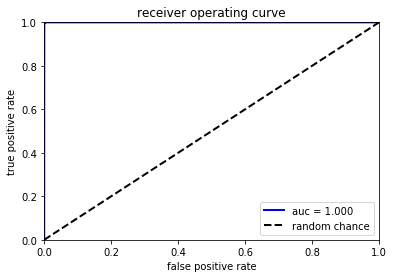

In [7]:
# Plot ROC
predict = best_model.predict(train_batch)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(trainlabels[:,0].flatten(), predict[:,0].flatten())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

In [8]:
#1D CNN WITH XAUG INPUTS

In [9]:
def build_xaug():
    input0 = layers.Input(name = 'pt_input', batch_shape=(None,batch, 1) )
    input1 = layers.Input(name = 'eta_input', batch_shape=(None,batch, 1) )
    input2 = layers.Input(name = 'phi_input', batch_shape=(None,batch, 1) )
    input3 = layers.Input(name = 'mass_input', batch_shape=(None,batch, 1) )
    x = layers.concatenate(inputs = [input0, input1, input2, input3],axis=-1, name = 'concat1')
    x = layers.Conv1D(64, 3, padding = 'same', activation='relu', name = 'conv1')(x)
    x = layers.Conv1D(64, 1, padding = 'same', activation='relu', name = 'conv2')(x)
    x = layers.MaxPool1D(2, name = "maxpool1")(x)
    x = layers.Conv1D(32, 3, padding = 'same', activation='relu', name = 'conv3')(x)
    x = layers.Conv1D(32, 1, padding = 'same', activation='relu', name = 'conv4')(x)
    x = layers.MaxPool1D(2, name = 'maxpool2')(x)
    x = layers.Flatten(name = 'flatten1')(x)
    input4 = layers.Input(batch_shape=(None,batch,), name = 'zinput')
    input5 = layers.Input(batch_shape=(None,batch,), name = 'rinput')
    input6 = layers.Input(batch_shape=(None,batch,), name = 'thetainput')
    x = layers.concatenate(inputs = [x, input4, input5, input6],axis=-1, name = 'concat2')
    x = layers.Dense(64, activation='relu', name = 'relu')(x)
    output = layers.Dense(2, activation='softmax', name = 'output')(x)  #switch to sigmoid
    model = models.Model(inputs=[input0, input1, input2, input3, input4, input5, input6], outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['categorical_crossentropy', 'accuracy'])
    return model

In [18]:
CNN_XAUG = build_xaug()
train_batch = [train_pt, train_eta, train_phi, train_mass, train_z, train_r, train_theta]

In [19]:
example_batch = [train_pt[:10], train_eta[:10], train_phi[:10], train_mass[:10], train_z[:10], train_r[:10], train_theta[:10]]
example_labels = trainlabels[:10]
example_result = CNN_XAUG.predict(x = example_batch)
results = CNN_XAUG.evaluate(x = example_batch, y = example_labels, verbose = 0)
print(example_result)
print(results)

[[0.6446766  0.35532334]
 [0.9402984  0.05970158]
 [0.87180156 0.12819847]
 [0.99523795 0.00476207]
 [0.29283395 0.707166  ]
 [0.91549623 0.0845037 ]
 [0.1835899  0.81641006]
 [0.08375311 0.91624695]
 [0.8875588  0.11244117]
 [0.05440696 0.945593  ]]
[0.9164445996284485, 0.9164445996284485, 0.6000000238418579]


In [20]:
checkpoint_path = "model/CNN1D_XAUG.h5"
if not os.path.exists("model"):
    os.mkdir("model")

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto')    
EPOCHS = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = CNN_XAUG.fit(
  train_batch, trainlabels,
  epochs=EPOCHS, validation_split = 0.2, verbose = 0,
  callbacks=[early_stop, model_checkpoint])


Epoch 00001: val_loss improved from inf to 0.01034, saving model to model/CNN1D_XAUG.h5

Epoch 00002: val_loss improved from 0.01034 to 0.00966, saving model to model/CNN1D_XAUG.h5

Epoch 00003: val_loss did not improve from 0.00966

Epoch 00004: val_loss improved from 0.00966 to 0.00220, saving model to model/CNN1D_XAUG.h5

Epoch 00005: val_loss improved from 0.00220 to 0.00109, saving model to model/CNN1D_XAUG.h5

Epoch 00006: val_loss improved from 0.00109 to 0.00043, saving model to model/CNN1D_XAUG.h5

Epoch 00007: val_loss improved from 0.00043 to 0.00018, saving model to model/CNN1D_XAUG.h5

Epoch 00008: val_loss did not improve from 0.00018

Epoch 00009: val_loss did not improve from 0.00018

Epoch 00010: val_loss did not improve from 0.00018

Epoch 00011: val_loss did not improve from 0.00018

Epoch 00012: val_loss did not improve from 0.00018

Epoch 00013: val_loss improved from 0.00018 to 0.00014, saving model to model/CNN1D_XAUG.h5

Epoch 00014: val_loss did not improve fr

In [22]:
!ls model
test_batch = [test_pt, test_eta, test_phi, test_mass, test_z, test_r, test_theta]
best_model = keras.models.load_model('model/CNN1D_XAUG.h5')
best_model.summary()
results = best_model.evaluate(test_batch, testlabels, verbose = 0)
print(results)

4MLP.h5			CNN_test.h5			  RNN_4GRU.h5
CNN1D.h5		CNN_XAUG_image.h1		  RNN_5GRU.h5
CNN1D_v3.h5		MLP.h5				  RNN.h5
CNN1D_XAUG.h5		RNN_1dense_4GRU.h5		  RNN_jetqandml.h5
CNN_cat_multi_input.h5	RNN_2x2048_2x512_1batchrenorm.h5  RNN_XAUG.h5
CNN_class_leakyrelu.h5	RNN_4GRU_gradclip.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pt_input (InputLayer)           (None, 10, 1)        0                                            
__________________________________________________________________________________________________
eta_input (InputLayer)          (None, 10, 1)        0                                            
__________________________________________________________________________________________________
phi_input (InputLayer)          (None, 10, 1)        0                                            
___________________________

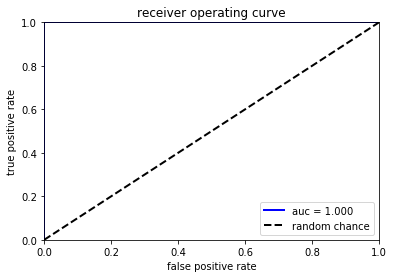

In [24]:
# Plot ROC
predict = best_model.predict(test_batch)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testlabels[:,0].flatten(), predict[:,0].flatten())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='blue', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()